# **EXERCISE: GNN application: Drug Discovery**

In this tutorial we will learn how to use GNNs for graph-level predictions with Drug Discovery as a use case. Please install the following dependencies:


*   **RDkit**: A library for Chemoinformatics and Drug Discovery, we will use this to generate features.
*   **Pytorch & Pytorch-Geometric**: Pytorch-Geometric (PyG) will be used to develop our GNN Model. Since PyG is dependent on Pytorch, we need to install them both.



In [ ]:
!pip install rdkit

In [ ]:
!pip install torch

In [ ]:
!pip install torch_geometric

# **Section 1: Loading libraries and data**

In this exercise we will build a model to predict P-Glycoprotein (PgP) Inhibitors using the PgP dataset obtained from [OCHEM Database](https://ochem.eu/home/show.do).

The dataset given below is already cleaned for invalid and duplicate SMILES to avoid any errors and biases. In the dataset below each molecule is represented by a SMILES and its status or label (**PgP inhibitor: 1** and **PgP non-inhibitor: 0**). Hence, it's a simple binary-classification problem.

Please load the libraries and train and test data mentioned below:

In [ ]:
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import logging
import pickle

In [ ]:
!pwd

/content


In [ ]:
import zipfile
import os

zip_path = '/content/sk_icgeb_w2025.zip'
extract_dir = '/content/'

os.makedirs(extract_dir, exist_ok=True)

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

print("Extracted to:", extract_dir)
!ls $extract_dir

Extracted to: /content/
sample_data  sk_icgeb_w2025  sk_icgeb_w2025.zip


In [ ]:
train_val_df = pd.read_csv('/content/sk_icgeb_w2025/train_pgp_inhibitor_filtered_1111.csv')
test_df = pd.read_csv('/content/sk_icgeb_w2025/test_pgp_inhibitor_filtered_1111.csv')

In [ ]:
train_val_df

canonical_smiles  PgP inhibitor
0                         O=[N+]([O-])c1ccc(Cl)c2nonc12              1
1                              COc1cc(/C=C/C(=O)O)ccc1O              0
2     COc1ccc([C@]2(c3ccccc3)NC(=O)N(CCCN3CCC(c4cccc...              1
3     CC(C)C(NC(=O)[C@H](CCC(=O)O)NC(=O)[C@H](Cc1ccc...              0
4     C[C@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C@...              0
...                                                 ...            ...
3238           COc1ccc(-n2c(C(=N)CCC(N)=O)n[nH]c2=S)cc1              0
3239  O=C(CCc1cccc2ccccc12)c1ccccc1OC[C@@H](O)CN1CCOCC1              1
3240  C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...              1
3241  Cl/C=C1/[C@@H]2C[C@H]([C@@H](Cl)C2(Cl)Cl)C1(CC...              0
3242  O=C1NC(c2ccccc2)(c2ccccc2)C(=O)N1CCCN1CCC(c2cc...              1

[3243 rows x 2 columns]

Let's check the distribution of PgP inhibitors and non-inhibitors in our train + validation dataset by their molecular weight. This will help us to avoid any outliers by molecular weight and also check the class-imbalance.

[06:04:21] WARNING: not removing hydrogen atom without neighbors


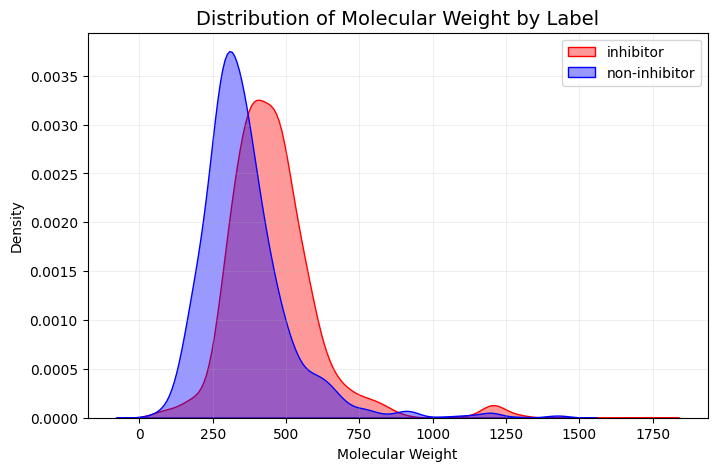

In [ ]:
# Compute molecular weights
def mol_weight(smiles):
    mol = Chem.MolFromSmiles(smiles)
    return Descriptors.MolWt(mol) if mol else None

train_val_df['MolWeight'] = train_val_df['canonical_smiles'].apply(mol_weight)
train_val_df = train_val_df.dropna(subset=['MolWeight'])

# Plot distribution
plt.figure(figsize=(8, 5))
sns.kdeplot(train_val_df[train_val_df['PgP inhibitor'] == 1]['MolWeight'], color='red', label='inhibitor', fill=True, alpha=0.4)
sns.kdeplot(train_val_df[train_val_df['PgP inhibitor'] == 0]['MolWeight'], color='blue', label='non-inhibitor', fill=True, alpha=0.4)

plt.title('Distribution of Molecular Weight by Label', fontsize=14)
plt.xlabel('Molecular Weight')
plt.ylabel('Density')
plt.legend()
plt.grid(alpha=0.2)
plt.show()

In [ ]:
train_val_df['PgP inhibitor'].value_counts() # this ratio will help us to deal with class-imbalance.

PgP inhibitor
1    1915
0    1328
Name: count, dtype: int64

# **Section 2: Feature Generation**

Now we will generate features using SMILES. To do this we require RDKit and DeepChem to calculate atomic-level features which is different from Molecular-Level Features. DeepChem is built upon RDKit, please make sure you have the `deepchem_utils.py` file in the same directory as this colab notebook and the datasets.

Let's understand how atomic-level features differ from molecular-level features. Since molecules can be represented as graphs, each atom in the molecule can be seen as an atom and each bond can be seen as an edge. This is why we require atomic (node)- level features as also discussed in my presentation that we require 2 essentials for GNNs i.e., node-feature matrix and adjacency matrix.

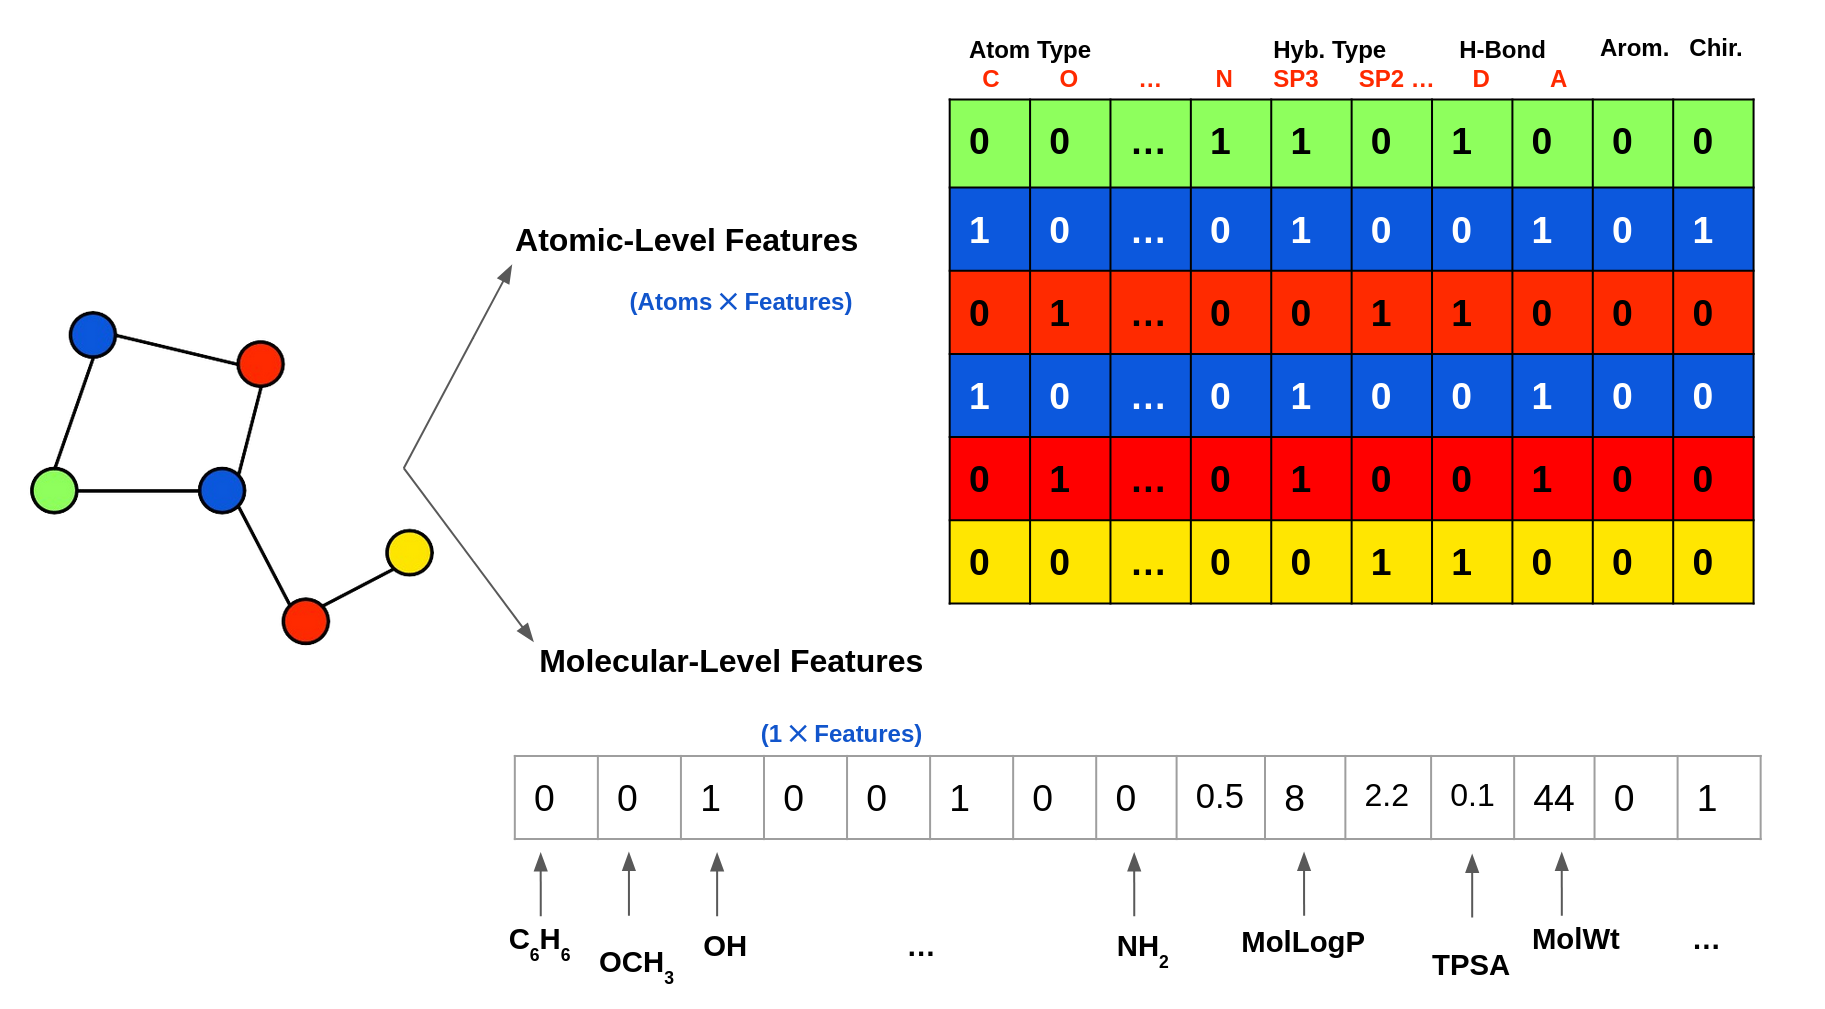

In [ ]:
sys.path.append('/content/sk_icgeb_w2025')

from deepchem_utils import encode_with_one_hot, atom_type_one_hot, get_hybridization_one_hot, construct_hydrogen_bonding_info, get_atom_formal_charge
from deepchem_utils import get_atom_is_in_aromatic_one_hot, get_atom_total_degree_one_hot, get_atom_total_num_Hs_one_hot, get_chirality_one_hot
from deepchem_utils import smiles_to_edge_indices

In [ ]:
import torch
from torch_geometric.data import DataLoader, Data, Batch

In [ ]:
class MolGraphConvFeaturizer():

    def __init__(self):
        pass

    def check_valid_smiles(self, smile):
        mol = Chem.MolFromSmiles(smile)
        if mol is None:
            return False, "Invalid SMILES string provided"
        num_atoms = mol.GetNumAtoms()
        if num_atoms == 1:
            return False, "The provided SMILES represents a single atom, not a compound."
        return True, ""


    def featurize_one(self, smile):

        is_valid, error_msg = self.check_valid_smiles(smile)
        if not is_valid:
            raise ValueError(error_msg)

        encoder = MolGraphConvFeaturizer()
        atom_type = atom_type_one_hot(smile)
        formal_charge = get_atom_formal_charge(smile)
        hybridization = get_hybridization_one_hot(smile)
        hydrogen_bonding_info = construct_hydrogen_bonding_info(smile)
        aromatic = get_atom_is_in_aromatic_one_hot(smile)
        degree = get_atom_total_degree_one_hot(smile)
        num_Hs = get_atom_total_num_Hs_one_hot(smile)
        chirality = get_chirality_one_hot(smile)

        # Concatenate features
        node_features = torch.cat((atom_type, formal_charge, hybridization, hydrogen_bonding_info,
                                           aromatic, degree, num_Hs, chirality), dim=1)

        return node_features

    def get_edge_index(self, smile):

        encoder = MolGraphConvFeaturizer()
        edge_index = smiles_to_edge_indices(smile)

        return edge_index

    def create_data_object(self, smile, label):
        node_features = self.featurize_one(smile)
        edge_index = self.get_edge_index(smile)
        label_tensor = torch.tensor(label, dtype=torch.int64).view(1, 1)
        data = Data(x=node_features, edge_index=edge_index, y=label_tensor)
        return data

    def get_graphs(self, smiles_series, label_series):

        smiles_list = smiles_series.tolist()
        labels_list = label_series.tolist()

        graphs = []

        for smile, label in zip(smiles_list, labels_list):
            is_valid, error_msg = self.check_valid_smiles(smile)
            if not is_valid:
                logging.warning(f"Skipping invalid SMILES: {smile} - {error_msg}")
                continue
            try:
                data_object = self.create_data_object(smile, label)
                graphs.append(data_object)
            except Exception as e:
                logging.warning(f"Skipping SMILES due to featurization error: {smile} - {e}")
                continue


        graph_object = Batch.from_data_list(graphs)

        return graph_object

In [ ]:
featurizer = MolGraphConvFeaturizer()
train_val_set = featurizer.get_graphs(train_val_df['canonical_smiles'], train_val_df['PgP inhibitor'])
test_set = featurizer.get_graphs(test_df['canonical_smiles'], test_df['PgP inhibitor'])

[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors
[10:37:22] WARNING: not removing hydrogen atom without neighbors


In [ ]:
train_val_set

DataBatch(x=[96624, 33], edge_index=[2, 208938], y=[3243, 1], batch=[96624], ptr=[3244])

In [ ]:
train_val_set[0].x

tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
         0., 

In [ ]:
train_val_set[1].x.shape # check the shapes of different graphs (molecules in our case).

torch.Size([14, 33])

#**Section 3: Data Split**

Let's split the data using stratified sampling to keep the balance in both train and validation set.

In [ ]:
# Check if CUDA (GPU) is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [ ]:
from torch_geometric.data import DataLoader, Data, Batch
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

import torch.nn.functional as F

# Get the labels from your dataset
train_val_labels = train_val_set.y.flatten().tolist()

data_size = len(train_val_set)

In [ ]:
# change random state with every change in random seed for model
split_train_val = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=33)
train_indices, val_indices = next(split_train_val.split(train_val_set, train_val_labels))

# Separate labels for train and val-test
train_labels = [train_val_labels[i] for i in train_indices]
val_labels = [train_val_labels[i] for i in val_indices]

train_set = train_val_set[train_indices]
val_set = train_val_set[val_indices]

train_set = Batch.from_data_list(train_set)
val_set = Batch.from_data_list(val_set)

In [ ]:
import numpy as np
from collections import Counter

# Assuming your dataset is named 'data'
y_values = train_set.y.numpy()  # Convert y tensor to numpy array
unique_values = np.unique(y_values)
counts = Counter(y_values.flatten())

print("Unique values of y:", unique_values)
print("Counts of unique values:", counts)

Unique values of y: [0 1]
Counts of unique values: Counter({np.int64(1): 1532, np.int64(0): 1062})


In [ ]:
# train_set.x = train_set.x.to(torch.float32).cuda()
# train_set.y = train_set.y.cuda()
# train_set.edge_index = train_set.edge_index.cuda()

# val_set.x = val_set.x.to(torch.float32).cuda()
# val_set.y = val_set.y.cuda()
# val_set.edge_index = val_set.edge_index.cuda()

# test_set.x = test_set.x.to(torch.float32).cuda()
# test_set.y = test_set.y.cuda()
# test_set.edge_index = test_set.edge_index.cuda()

# **Section 4: Model Development**

So now we have the dataset in our torch-geometric object, now it's time to build the model step-by-step:


1.   Model Development
2.   Fix the Batch Size
3.   Load the Dataset in Dataloader
4.   Fix the class-imbalance
5.   Define the Loss-Function
6.   Set the optimizer and scheduler for learning
7.   Define a function for evaluation metrics
8.   Define the train and validation functions
9.   Set the epochs and train the model

In [ ]:
import torch.nn.functional as F
from torch.nn import Linear, Sequential, ELU, GELU
from torch_geometric.nn import GINConv, GCNConv, GraphConv, GraphNorm, GINEConv, GATConv, SAGEConv
from torch_geometric.nn import global_add_pool as gap, global_max_pool as gmp
from torch.nn import Linear
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch_geometric.nn import GraphConv, GCNConv
from torch_geometric.nn import global_add_pool as gap
from torch.nn import Dropout

In [ ]:
class GraphConvModel(torch.nn.Module):
    def __init__(self, embedding_size, num_classes):
        super(GraphConvModel, self).__init__()
        torch.manual_seed(821)

        self.initial_conv = GraphConv(train_set.num_features, embedding_size)
        self.conv1 = GraphConv(embedding_size, embedding_size)
        self.conv2 = GraphConv(embedding_size, embedding_size)
        self.conv3 = GraphConv(embedding_size, embedding_size)

        self.out = torch.nn.Linear(embedding_size, 1)
        self.dropout = torch.nn.Dropout(p=0.5)

    def forward(self, x, edge_index, batch_index):
        hidden = self.initial_conv(x, edge_index)
        hidden = F.elu(hidden)
        hidden = self.dropout(hidden)

        hidden = self.conv1(hidden, edge_index)
        hidden = F.elu(hidden)
        hidden = self.dropout(hidden)

        hidden = self.conv2(hidden, edge_index)
        hidden = F.elu(hidden)
        hidden = self.dropout(hidden)

        hidden = self.conv3(hidden, edge_index)
        hidden = F.elu(hidden)
        hidden = self.dropout(hidden)

        hidden = gap(hidden, batch_index)

        out = self.out(hidden)
        return out

In [ ]:
#model = GraphConvModel(embedding_size=128, num_classes=2).to(device)
model = GraphConvModel(embedding_size=128, num_classes=2)
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GraphConvModel(
  (initial_conv): GraphConv(33, 128)
  (conv1): GraphConv(128, 128)
  (conv2): GraphConv(128, 128)
  (conv3): GraphConv(128, 128)
  (out): Linear(in_features=128, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)
Number of parameters:  107393


In [ ]:
from torch_geometric.data import DataLoader
from sklearn.model_selection import StratifiedShuffleSplit
import warnings
warnings.filterwarnings("ignore")

NUM_GRAPHS_PER_BATCH = 32

In [ ]:
# Create data loaders
train_loader = DataLoader(train_set, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
val_loader = DataLoader(val_set, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)
test_loader = DataLoader(test_set, batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

In [ ]:
#imbalance_ratio = torch.tensor([1061/1532]).cuda()
imbalance_ratio = torch.tensor([1061/1532])

In [ ]:
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=imbalance_ratio)

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.95, patience=10)

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, precision_score, recall_score
from sklearn.metrics import roc_auc_score, average_precision_score, confusion_matrix

In [ ]:
def calculate_metrics(y_true, y_pred, y_score=None):
    """
    Calculate and print classification metrics.

    Args:
    - y_true (array-like): True labels.
    - y_pred (array-like): Predicted labels.
    - y_score (array-like): Target scores, can either be probability estimates of the positive class,
                            confidence values, or non-thresholded measure of decisions (as returned by
                            "decision_function" on some classifiers).
    """

    # Basic metrics
    accuracy = accuracy_score(y_true, y_pred)
    balanced_acc = balanced_accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='binary')
    ck = cohen_kappa_score(y_true, y_pred)
    mcc = matthews_corrcoef(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    # Advanced metrics requiring score
    if y_score is not None:
        auc_roc = roc_auc_score(y_true, y_score)
        auc_pr = average_precision_score(y_true, y_score)
    else:
        auc_roc = None
        auc_pr = None

    # # Sensitivity, Specificity from confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    sensitivity = tp / (tp + fn) if (tp + fn) != 0 else None
    specificity = tn / (tn + fp) if (tn + fp) != 0 else None

    print(f"Acc: {accuracy:.4f}, "
          f"BAcc: {balanced_acc:.4f}, "
          f"{f'AUC-ROC: {auc_roc:.4f}, ' if auc_roc is not None else ''}"
          f"{f'AUC-PR: {auc_pr:.4f}, ' if auc_pr is not None else ''}"
          f"CK: {ck:.4f}, "
          f"MCC: {mcc:.4f}, "
          f"F1 Score: {f1:.4f}, "
          f"Precision: {precision:.4f}, "
          f"Recall: {recall:.4f}, "
          f"SN: {sensitivity:.4f}, "
          f"SP: {specificity:.4f}, "
        )

    metrics = {
        "Acc": accuracy,
        "BAcc": balanced_acc,
        "MCC": mcc,
        "F1-score":f1}

    return metrics

In [ ]:
def train(data_loader, is_validation=False):
    model.train() if not is_validation else model.eval()

    loss_total = 0
    y_true = []
    y_pred = []
    y_score = []

    for batch in data_loader:
        optimizer.zero_grad()
        pred = model(batch.x.float(), batch.edge_index.long(), batch.batch.long())
        probs = torch.sigmoid(pred)
        target = batch.y.float()
        loss = loss_fn(pred, target)  # using raw logits here as we are using BCEWithLogitsLoss

        if not is_validation:
            loss.backward()
            optimizer.step()

        predicted = (pred >= 0.0).float()

        y_true.extend(target.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_score.extend(probs.detach().cpu().numpy()) # to obtain the probability score applying sigmoid function to raw logits

        loss_total += loss.item()

    loss_avg = loss_total / len(data_loader)

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    metrics = calculate_metrics(y_true, y_pred, y_score)

    return loss_avg, metrics

def validate(data_loader):
    return train(data_loader, is_validation=True)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
best_val_loss = float('inf')
best_epoch = 0
best_mcc = -1

train_losses = []
val_losses = []

for epoch in range(600):

    print(f'Epoch {epoch} Training Metrics:')
    train_loss, train_metrics = train(train_loader)

    print(f'Epoch {epoch} Test Metrics:')
    val_loss, val_metrics = validate(val_loader)
    train_mcc = train_metrics['MCC']
    val_mcc = val_metrics['MCC']

    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print('----------------------------------------------------------------------------')

    if train_mcc > val_mcc:
        if val_mcc > best_mcc:
            best_mcc = val_mcc
            best_epoch = epoch
        # Save the model weights
            torch.save(model.state_dict(), '/content/sk_icgeb_w2025/pgp_inhibitor_best_mcc_model_weights_821.pth')
            print(f'Best MCC improved to {best_mcc:.4f} at epoch {best_epoch}')

    scheduler.step(val_loss)

# Optionally, print the final best epoch after the loop ends
print(f'The model achieved the best MCC of {best_mcc:.4f} at epoch {best_epoch}')

Epoch 0 Training Metrics:
Acc: 0.5451, BAcc: 0.5331, AUC-ROC: 0.5513, AUC-PR: 0.6372, CK: 0.0658, MCC: 0.0659, F1 Score: 0.6088, Precision: 0.6186, Recall: 0.5992, SN: 0.5992, SP: 0.4670, 
Epoch 0 Test Metrics:
Acc: 0.5994, BAcc: 0.5124, AUC-ROC: 0.8171, AUC-PR: 0.8302, CK: 0.0291, MCC: 0.0992, F1 Score: 0.7456, Precision: 0.5962, Recall: 0.9948, SN: 0.9948, SP: 0.0301, 
----------------------------------------------------------------------------
Epoch 1 Training Metrics:
Acc: 0.5709, BAcc: 0.5559, AUC-ROC: 0.5903, AUC-PR: 0.6715, CK: 0.1118, MCC: 0.1118, F1 Score: 0.6376, Precision: 0.6361, Recall: 0.6390, SN: 0.6390, SP: 0.4727, 
Epoch 1 Test Metrics:
Acc: 0.6086, BAcc: 0.5266, AUC-ROC: 0.7689, AUC-PR: 0.7926, CK: 0.0616, MCC: 0.1333, F1 Score: 0.7475, Precision: 0.6035, Recall: 0.9817, SN: 0.9817, SP: 0.0714, 
----------------------------------------------------------------------------
Epoch 2 Training Metrics:
Acc: 0.6037, BAcc: 0.5911, AUC-ROC: 0.6240, AUC-PR: 0.6878, CK: 0.1819, 

# **Section 5: Results and Visualization**

Once the model is built, we can check the progress with train and validation losses over the entire training period. After this we will test the model on our held-out test set. We are also making 3 plots for confusion matrix, AUC-ROC, AUC-PR curve on the test set below.

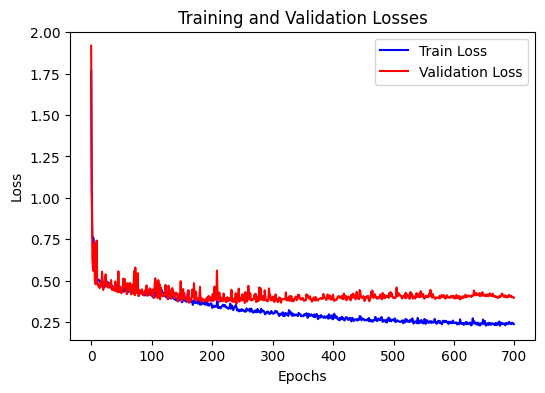

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

epochs = range(0, 600)

# Plotting losses
plt.figure(figsize=(6, 4))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Validation Loss', color='red')
plt.title('Training and Validation Losses')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(False)
plt.show()

In [ ]:
def test(data_loader):
    model.eval()
    loss_total = 0
    y_true = []
    y_pred = []
    y_score = []

    with torch.no_grad():
        for batch in data_loader:
            pred = model(batch.x.float(), batch.edge_index.long(), batch.batch.long())
            probs = torch.sigmoid(pred)
            target = batch.y.float()
            loss = loss_fn(pred, target)

            predicted = (pred >= 0.0).float()

            y_true.extend(target.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            y_score.extend(probs.detach().cpu().numpy()) # to obtain the probability score applying sigmoid function to raw logits

            loss_total += loss.item()

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    y_score = np.array(y_score)

    metrics = calculate_metrics(y_true, y_pred, y_score)

    loss_avg = loss_total / len(data_loader)
    return loss_avg, metrics, y_true, y_pred, y_score

In [ ]:
test_loss, test_metrics, y_true, y_pred, y_score = test(test_loader)
print(f'Loss: {test_loss:.4f}')

Acc: 0.8323, BAcc: 0.8285, AUC-ROC: 0.8991, AUC-PR: 0.9248, CK: 0.6545, MCC: 0.6546, F1 Score: 0.8568, Precision: 0.8641, Recall: 0.8497, SN: 0.8497, SP: 0.8072, 
Loss: 0.3694


In [ ]:
y_true = y_true.flatten()
y_pred = y_pred.flatten()
y_score = y_score.flatten()

test_pred = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred, 'y_score': y_score})
test_pred

y_true  y_pred   y_score
0       1.0     1.0  0.973256
1       0.0     1.0  0.778793
2       1.0     0.0  0.405567
3       1.0     1.0  0.963350
4       1.0     1.0  0.631381
..      ...     ...       ...
806     1.0     0.0  0.109419
807     0.0     0.0  0.001045
808     0.0     0.0  0.020994
809     0.0     0.0  0.322824
810     1.0     0.0  0.033749

[811 rows x 3 columns]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    roc_curve, roc_auc_score,
    precision_recall_curve, average_precision_score,
    confusion_matrix, classification_report
)

# The test set we built above have these columns: 'y_true', 'y_pred', 'y_score'
y_true = test_pred['y_true']
y_pred = test_pred['y_pred']
y_score = test_pred['y_score']  # probability score

# AUC scores
auc_roc = roc_auc_score(y_true, y_score)
auc_pr = average_precision_score(y_true, y_score)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm

array([[268,  64],
       [ 72, 407]])

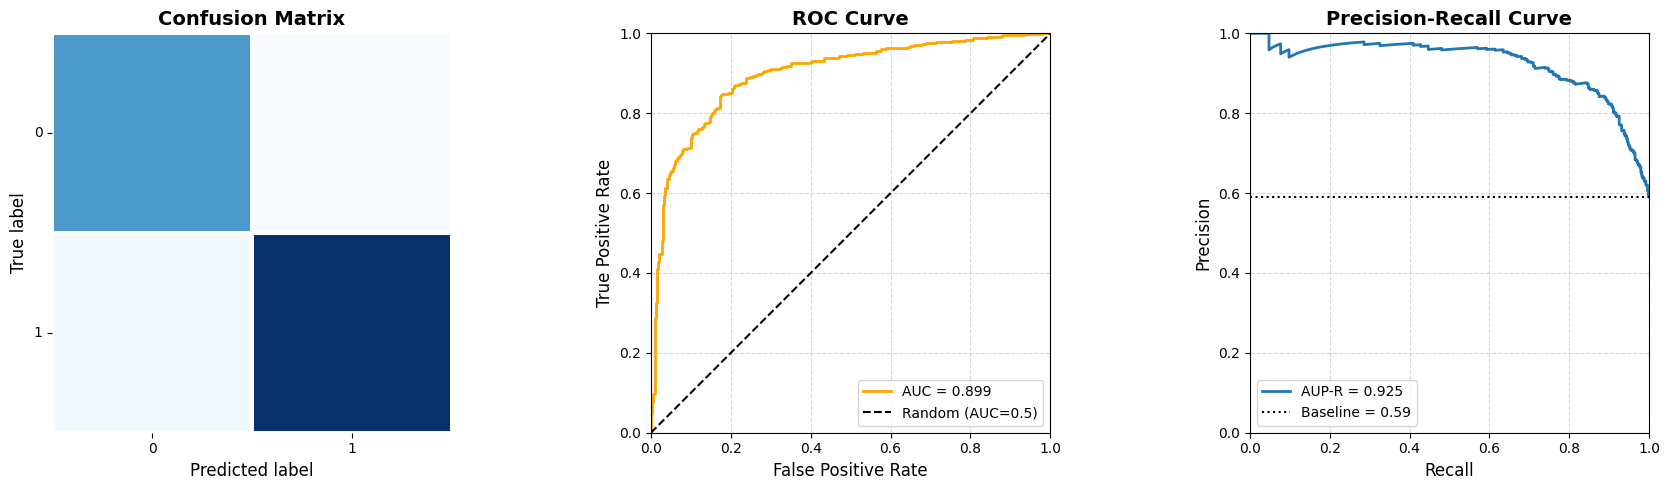

In [ ]:
label_fontsize = 12
title_fontsize = 14

# First, create a horizontal figure with 3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns

# 1: Confusion Matrix
sns.heatmap(
    cm, annot=False, cmap='Blues', cbar=False,
    square=True, linewidths=1.5, linecolor='white',
    ax=axes[0]
)
axes[0].set_xlabel("Predicted label", fontsize=label_fontsize)
axes[0].set_ylabel("True label", fontsize=label_fontsize)
axes[0].set_title("Confusion Matrix", fontsize=title_fontsize, weight="bold")
axes[0].tick_params(axis='y', rotation=0)

# 2: ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_score)
axes[1].plot(fpr, tpr, color='orange', label=f"AUC = {auc_roc:.3f}", linewidth=2)
axes[1].plot([0, 1], [0, 1], 'k--', label="Random (AUC=0.5)")
axes[1].set_xlabel("False Positive Rate", fontsize=label_fontsize)
axes[1].set_ylabel("True Positive Rate", fontsize=label_fontsize)
axes[1].set_title("ROC Curve", fontsize=title_fontsize, weight="bold")
axes[1].legend(loc="lower right")
axes[1].grid(True, linestyle='--', alpha=0.5)
axes[1].axis('square')
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 1)

# 3: Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_true, y_score)
baseline = y_true.mean()
axes[2].plot(recall, precision, label=f"AUP-R = {auc_pr:.3f}", linewidth=2)
axes[2].hlines(baseline, 0, 1, colors='k', linestyles='dotted', label=f"Baseline = {baseline:.2f}")
axes[2].set_xlabel("Recall", fontsize=label_fontsize)
axes[2].set_ylabel("Precision", fontsize=label_fontsize)
axes[2].set_title("Precision-Recall Curve", fontsize=title_fontsize, weight="bold")
axes[2].legend(loc="lower left")
axes[2].grid(True, linestyle='--', alpha=0.5)
axes[2].axis('square')
axes[2].set_xlim(0, 1)
axes[2].set_ylim(0, 1)

plt.tight_layout()
plt.savefig("/content/sk_icgeb_w2025/metrics_summary.png", dpi=300, bbox_inches='tight')
plt.show()

# **Section 6: Homework**

1. Try **Hyperparameter Tuning**, make changes in the function, e.g. changing activation function, learning rate, optimizer, no. of convolution layers, no. of final features, batch size, number of linear layers, etc., play around and see if you can improve the current results.
2. Try **different graph convolution** layers from the given link: [Torch-Geometric-Convolution-Layers](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#convolutional-layers)
3. Download a different dataset of molecules from **OCHEM**, or if you already have one please use that.
4. **Develop** and **deploy** your own model as your own GNN project.